# $x^2$ potential

In [1]:
import pickle
import numpy as np
import pycuda.gpuarray as gpuarray
from scipy.special import hyp1f1
import scipy.fftpack as fftpack
import pylab as plt
import time

#-------------------------------------------------------------------------------------
from pywignercuda_path import SetPyWignerCUDA_Path
SetPyWignerCUDA_Path()
from GPU_Wigner2D_GPitaevskii import *


In [2]:
%matplotlib inline

## Settings

In [3]:
class frame( GPU_Wigner2D_GPitaevskii ):
    def __init__ (self,V_Source, V_Drain, gaussianSeparation):
        X_gridDIM = 2*512
        P_gridDIM =   512
        
        X_amplitude  = 32
        P_amplitude  = 18
        
        hBar = 1.
        dt    = 0.01
        
        timeSteps =       5000
        skipFrames =       100
        
        mass = 1.      
        
        # Diffusion parameter 
        D_Theta  = 0.00
        D_Lambda = 0.00   
        
        # Damping parameters
        self.dampingFunction = 'CaldeiraLeggett'
        gammaDamping  = 0.0 #8*10**(-6)
        epsilon       = 0.5;
        self.fp_Damping_String = ' p*p/sqrt( p*p + {epsilon}  ) '.format( epsilon=epsilon )
        
        #
        self.xScale = 2.16074     #  with this scale the x axis reads in micro meters
        
        self.energyScale = 0.5    #  with this scale the energy reads in KHz
        
        self.timeScale = 2        #  with this scale the time reads in mili seconds
        
        # Potential and derivative of potential in computational units
        X2_constant = 0.075            # Enveloping Harmonic oscillator
        gaussianSeparation = 0.75
        V_Drain =  3.
        V_Source = 2.
        k = 5. # 1/width of Gaussian potentials
        
        self.GPitaevskiiCoeff = 1.
        
        kinematicString  = '0.5*p*p/{mass}'.format(mass=mass)
        
        #potentialString  = '(-0.1+{0}*pow(x,2) + {V_Source}*exp(-{k}*(x+{d})*(x+{d})))*Heaviside(-x-{d})'.format(
        #                X2_constant, d=gaussianSeparation, V_Source=V_Source, k=k)
        potentialString = \
        '-0.1+{0}*pow(x,2) + {2}*exp(-{4}*(x+{1})*(x+{1})) +  {3}*exp(-{4}*(x-{1})*(x-{1}))'.format(
                        X2_constant,gaussianSeparation,V_Source,V_Drain,k)
        
        dPotentialString = \
        '2*{0}*x-2*{4}*{2}*(x+{1})*exp(-{4}*(x+{1})*(x+{1}))-2*{4}*{3}*(x-{1})*exp(-{4}*(x-{1})*(x-{1}))'.format(
                        X2_constant,gaussianSeparation,V_Source,V_Drain,k)
        
        self.SetTimeTrack( dt, timeSteps, skipFrames,
        fileName='/home/rcabrera/DATA/Wigner2D_GPitaevskii/ATransistor_HO_'+str(V_Source)+'_'+str(V_Drain)+'.hdf5' )
        
        GPU_Wigner2D_GPitaevskii.__init__(self,
            X_gridDIM,P_gridDIM,X_amplitude,P_amplitude,
            hBar,mass,D_Theta,D_Lambda,gammaDamping,potentialString,dPotentialString,kinematicString)

    def Set_Ground_State(self):
        Ground_Dir = '/home/rcabrera/DATA/Wigner2D_GPitaevskii/'

        Ground_hdf5 = h5py.File( Ground_Dir+'ATransistor_Ground_2.0.hdf5' ,'r')

        self.W_init = Ground_hdf5['W_0'][...]+0j
        
        self.Potential_GroundState = Ground_hdf5['/Potential'][...]
        
    def Set_States_0_1(self):
        Ground_Dir = '/home/rcabrera/DATA/Wigner2D_GPitaevskii/'

        Ground_hdf5 = h5py.File( Ground_Dir+'ATransistor_Ground_2.0.hdf5' ,'r')

        self.W_init = Ground_hdf5['W_0'][...] + 0.2*Ground_hdf5['W_1'][...]+0j
        
        self.Potential_GroundState = Ground_hdf5['/Potential'][...]
        
    def Set_Initial_Condition_HarmonicOscillator(self):
        """
        Sets   self.PsiInitial_XP with the Wigner function of the Harmonic oscillator  
        """
        self.x_init = -2.5
        self.p_init = 0.
        omega = 1
        n = 0    
        self.W_init = self.Wigner_HarmonicOscillator(n, omega, self.x_init, self.p_init)

        
    def Set_Initial_Condition_Boltzmann_HalfHarmonicOscillator(self):
        """
        Sets   self.PsiInitial_XP with the Wigner function of the Harmonic oscillator  
        """
        self.x_init = -1.5
        self.p_init = 0.
        omega = 1.5
        nMax = 51    
  
        kT = 20 
        
        energies = np.array( map(  lambda n: omega*( 0.5 + n  ),  range(1, nMax+1 ,2)   ) )
  
        probabilities = np.exp( -energies/kT )
        
        probabilities = probabilities/np.sum(probabilities)
  
        #print 'prob ',probabilities
        
        self.W_init = probabilities[0]*self.Wigner_Half_HarmonicOscillator(1, omega, self.x_init, self.p_init)
        
        #print ' range ', range( 1 , (nMax-1)/2 +1 )
        
        for n in range( 1 , (nMax-1)/2 +1 ):
                self.W_init += probabilities[n]*self.Wigner_Half_HarmonicOscillator( 2*n+1 , omega, self.x_init, self.p_init)
        

## Run

In [4]:
chemicalPotential = 50 #computational units

V_Source = 60 - chemicalPotential
V_Drain = 70 - chemicalPotential

gaussianSeparation = 1.


instance = frame( V_Source, V_Drain, gaussianSeparation)
print '							'
print ' 	Wigner2D propagator with damping	'
print '							'
#print ' energy scale = ', instance.energyScale

#instance.Set_Ground_State ()

instance.Set_States_0_1()

							
 	Wigner2D propagator with damping	
							


/usr/lib/pymodules/python2.7/matplotlib/font_manager.py:1236: UserWarning: findfont: Font family ['Times'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/lib/pymodules/python2.7/matplotlib/font_manager.py:1246: UserWarning: findfont: Could not match :family=Bitstream Vera Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=24.0. Returning /usr/share/matplotlib/mpl-data/fonts/ttf/cmb10.ttf
  UserWarning)


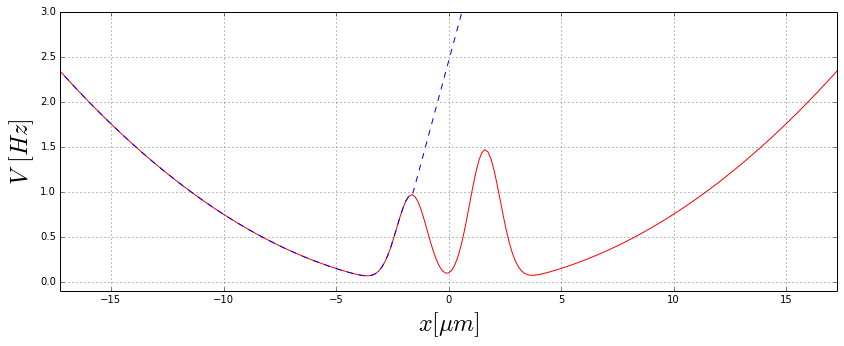

In [5]:
#print 'Potential'
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot( instance.X_range* instance.xScale , 
        instance.Potential(0,instance.X_range)* instance.energyScale ,'-' , color='r')

ax.plot( instance.X_range* instance.xScale , 
        instance.Potential_GroundState* instance.energyScale ,'--' , color='b')

ax.set_xlim( -instance.X_amplitude*instance.xScale/4 , instance.X_amplitude*instance.xScale/4 )
ax.set_ylim(-0.1 , 3 )
ax.set_aspect(4)
axis_font = {'fontname':'Times', 'size':'24'}
ax.set_xlabel('$ x [\\mu m]$', **axis_font  )
ax.set_ylabel('$ V\, [Hz]$', **axis_font  )
ax.grid('on')

In [6]:
init_time = time.time()

W = instance.Run()

print 'computation time = ', (time.time() - init_time)/60. , 'min'

 X_gridDIM =  1024    P_gridDIM =  512
 dx =  0.0625  dp =  0.0703125
 dLambda =  0.0981747704247  dTheta =  0.174532925199
  
         GPU memory Total        5.24945068359 GB
         GPU memory Free         5.09395599365 GB
Initial W Norm =  (1+0j)
         GPU memory Free  post gpu loading  5.03926849365 GB
 ------------------------------------------------------------------------------- 
     Split Operator Propagator  GPU with damping                                 
 ------------------------------------------------------------------------------- 
 progress  0 %
 progress  1 %
 progress  3 %
 progress  5 %
 progress  7 %
 progress  9 %
 progress  11 %
 progress  13 %
 progress  15 %
 progress  17 %
 progress  19 %
 progress  21 %
 progress  23 %
 progress  25 %
 progress  27 %
 progress  29 %
 progress  31 %
 progress  33 %
 progress  35 %
 progress  37 %
 progress  39 %
 progress  41 %
 progress  43 %
 progress  45 %
 progress  47 %
 progress  49 %
 progress  51 %
 progress  53 %

## Plots

min =  -0.00120243558048  max =  0.280808653414
normalization =  1.2


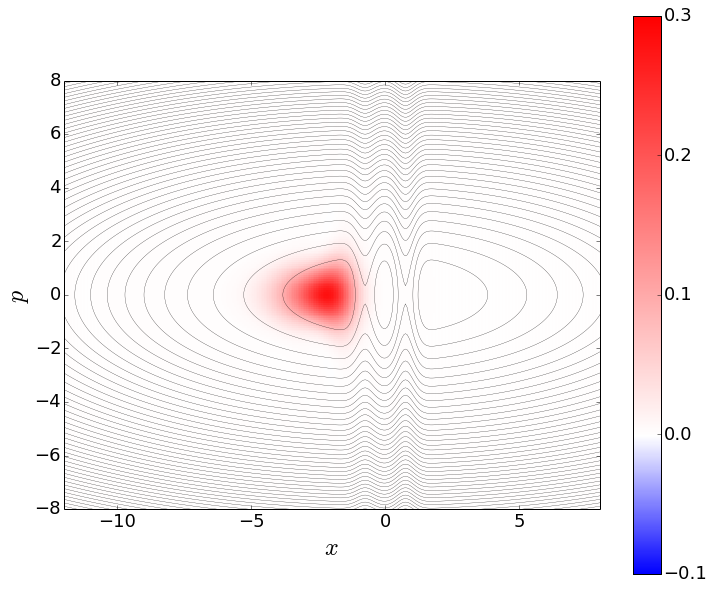

In [40]:
plot_init = instance.PlotWignerFrame( instance.W_init , ((-12.,8) ,(-8,8))  , (-0.1,0.3) , (0,60,1) )


min =  -0.0821639707795  max =  0.24925091415
normalization =  1.00002308288


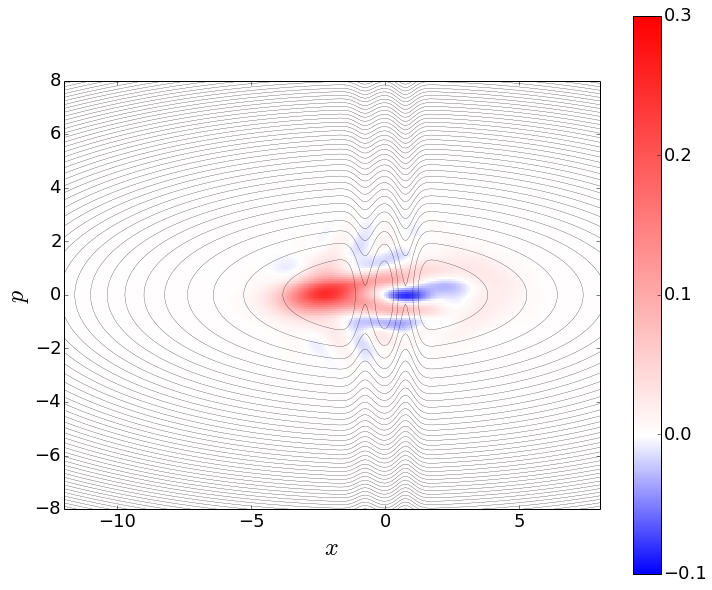

In [39]:
plot_end = instance.PlotWignerFrame( instance.W_end , ((-12.,8) ,(-8,8))  , (-0.1,0.3) , (0,60,1))

In [36]:
def PlotMarginal_x():
    fig, ax = plt.subplots(figsize=(15, 5))

    #
    W_end  = fftpack.fftshift( instance.W_end.real )
    W_init = fftpack.fftshift( instance.W_init.real  )

    dx    = instance.dX
    dp    = instance.dP
    p_min = -instance.P_amplitude
    p_max =  instance.P_amplitude - dp   

    x_min = -instance.X_amplitude
    x_max =  instance.X_amplitude - dx   

    energy = instance.Hamiltonian_average[0] + 0.5*instance.GPitaevskiiCoeff*instance.ProbabilitySquare_average[0]

    marginal_x_init =  instance.WignerMarginal_Probability_x(W_init)*(1./instance.xScale)
    marginal_x_end  =  instance.WignerMarginal_Probability_x(W_end)*(1./instance.xScale)

    # Potential
    ax.fill_between( instance.X_range* instance.xScale ,
                    instance.Potential(0,instance.X_range)* instance.energyScale , color='lightgray' )

    # Marginal x
    marginal_x_scale = energy/np.max(marginal_x_init)*instance.energyScale

    ax.plot(instance.X_range*instance.xScale , marginal_x_init*marginal_x_scale,
            '-',label='initial', linewidth=2.)

    ax.plot(instance.X_range*instance.xScale , marginal_x_end*marginal_x_scale,
            label='final', linewidth=2., color = 'red') 

    ax.set_xlim( -instance.X_amplitude*instance.xScale/4 , instance.X_amplitude*instance.xScale/4 )
    ax.set_ylim(-0.1 , 2.5 )
    ax.set_aspect(6.5)
    axis_font = {'fontname':'Times', 'size':'24'}
    ax.set_xlabel('$ x [\\mu m]$', **axis_font  )
    ax.set_ylabel('$ V\, [Hz]$', **axis_font  )
    ax.grid('on')

    ax.legend(loc='upper right', shadow=True)
    
def PlotMarginal_p():
    fig, ax = plt.subplots(figsize=(15, 5))

    #
    W_end  = fftpack.fftshift( instance.W_end.real )
    W_init = fftpack.fftshift( instance.W_init.real  )

    dx    = instance.dX
    dp    = instance.dP
    p_min = -instance.P_amplitude
    p_max =  instance.P_amplitude - dp   

    x_min = -instance.X_amplitude
    x_max =  instance.X_amplitude - dx   

    energy = instance.Hamiltonian_average[0] + 0.5*instance.GPitaevskiiCoeff*instance.ProbabilitySquare_average[0]

    marginal_p_init =  instance.WignerMarginal_Probability_p(W_init)
    marginal_p_end  =  instance.WignerMarginal_Probability_p(W_end)

    # Marginal p
    #marginal_x_scale = energy/np.max(marginal_x_init)*instance.energyScale

    ax.plot(instance.P_range , marginal_p_init,
            '-',label='initial', linewidth=2.)

    ax.plot(instance.P_range , marginal_p_end,
            label='final', linewidth=2., color = 'red') 

    ax.set_xlim( -instance.P_amplitude/4 , instance.P_amplitude/4 )
    ax.set_ylim(-0.1 , 1 )
    ax.set_aspect(4)
    axis_font = {'fontname':'Times', 'size':'24'}
    ax.set_xlabel('$ p $', **axis_font  )
    ax.set_ylabel('$ Probability $', **axis_font  )
    ax.grid('on')
    
    ax.legend(loc='upper right', shadow=True)

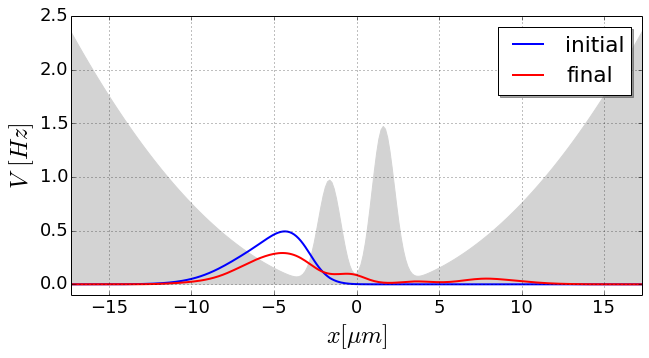

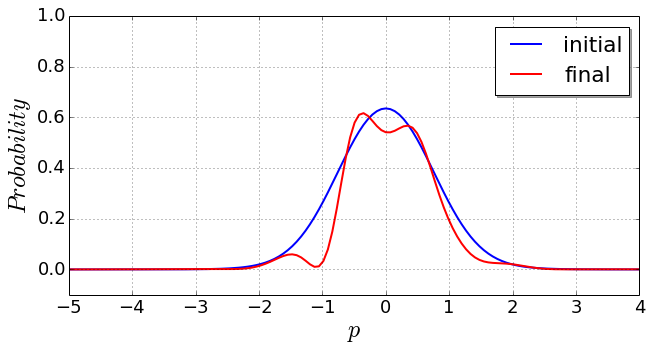

In [37]:
PlotMarginal_x()
PlotMarginal_p()

## First Order Ehrenfest

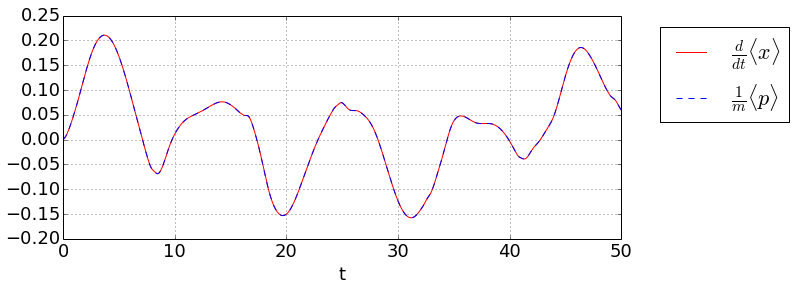

In [11]:
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot( instance.timeRange ,  np.gradient(instance.X_average, instance.dt) , '-',
        label = '$\\frac{d}{dt} \\langle x \\rangle $' ,color = 'red', linewidth=1.)

ax.plot( instance.timeRange ,  instance.P_average/instance.mass , '--' ,
        label='$\\frac{1}{m}\\langle p \\rangle$', linewidth=1. )


#ax.set_xlim(0,3.5)
#ax.set_ylim(-1.,1.2)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, prop={'size':22})
ax.set_xlabel('t')
ax.grid();

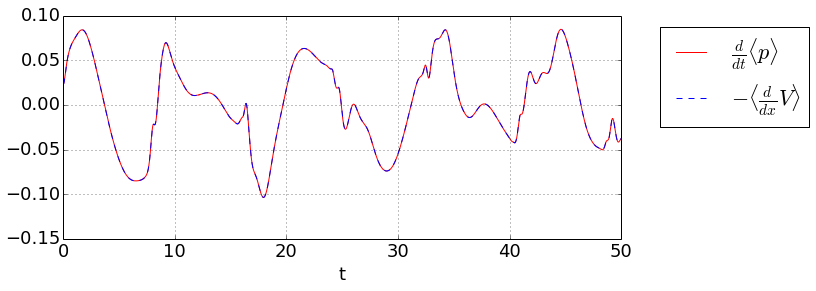

In [12]:
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot( instance.timeRange ,  np.gradient( instance.P_average , instance.dt) ,'-' , 
        label =  '$\\frac{d}{dt} \\langle p \\rangle $' ,color = 'r' , linewidth=1.)

ax.plot( instance.timeRange , 
        - instance.dPotentialdX_average    , '--' ,
        label = '$ -\\langle \\frac{d}{dx}V  \\rangle $' ,linewidth=1.)


ax.legend(bbox_to_anchor=(1.05, 1), loc=2, prop={'size':22})
#ax.set_ylim(-0.8,0.8)
ax.set_xlabel('t')
#ax.set_ylabel(' ')
ax.grid();

### Second Order Ehrenfest Theorems

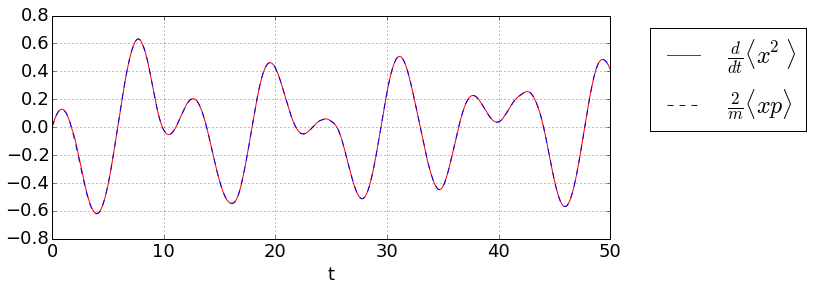

In [13]:
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot( instance.timeRange , np.gradient( instance.X2_average , instance.dt) , '-',
        label='$\\frac{d}{dt}  \\langle x^2  \\rangle$' , color = 'red', linewidth=1.)

ax.plot( instance.timeRange , \
        2*instance.XP_average/instance.mass, '--',label = '$\\frac{2}{m}  \\langle xp  \\rangle$',linewidth=1. )


#ax.set_xlim(0,3.5)
#ax.set_ylim(-1.,1.2)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, prop={'size':24})
ax.set_xlabel('t')
ax.grid();

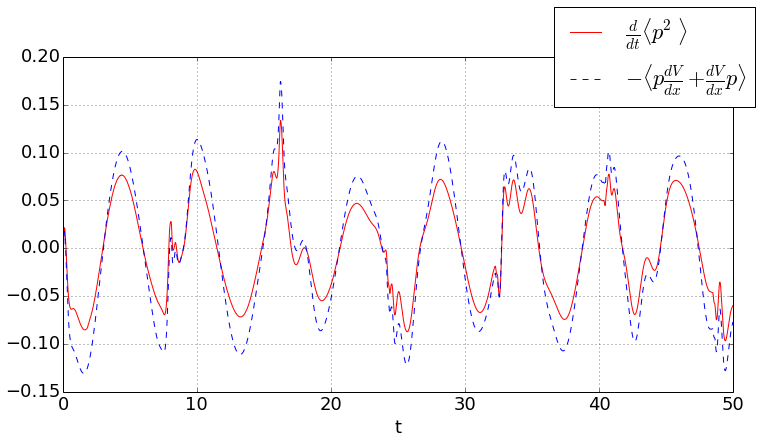

In [14]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot( instance.timeRange , np.gradient( instance.P2_average , instance.dt)  , '-',
        label = '$\\frac{d}{dt}  \\langle p^2  \\rangle$',
        color = 'red', linewidth=1.)

ax.plot( instance.timeRange , \
        -2*instance.PdPotentialdX_average
        , '--',
        label = '$-  \\langle p\\frac{dV}{dx} +\\frac{dV}{dx} p \\rangle  $',
        linewidth=1. )



#ax.set_xlim(-0.2,26)
#ax.set_ylim(-1.,1.2)
ax.legend(bbox_to_anchor=(1.05, 1), loc=5, prop={'size':22})
ax.set_xlabel('t')
ax.grid();

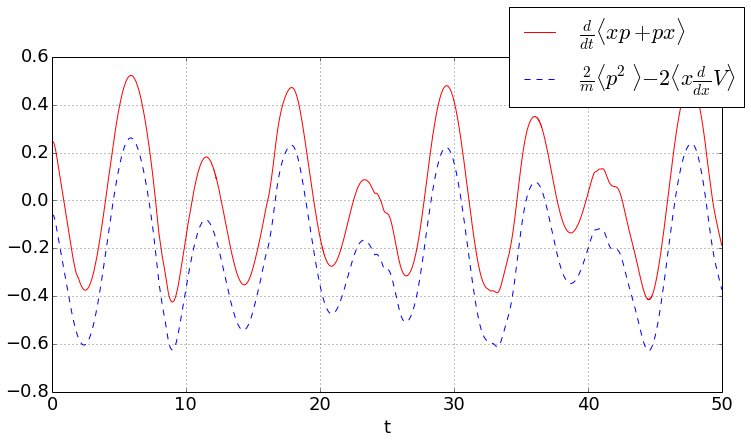

In [15]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot( instance.timeRange ,  2*np.gradient( instance.XP_average , instance.dt) ,
        '-' ,label = '$\\frac{d}{dt} \\langle xp+px  \\rangle$' , color = 'r' , linewidth=1. )

ax.plot( instance.timeRange , \
          2*instance.P2_average/instance.mass  \
         -2*instance.XdPotentialdX_average   
         , '--' , 
         label = '$\\frac{2}{m}  \\langle p^2  \\rangle - 2  \\langle x \\frac{d}{dx}V  \\rangle   $'
        ,linewidth=1.)


ax.legend(bbox_to_anchor=(1.05, 1), loc=5, prop={'size':22})
#ax.set_ylim(- 12 , 7)
ax.set_xlabel('t')
ax.set_ylabel(' ')
ax.grid();

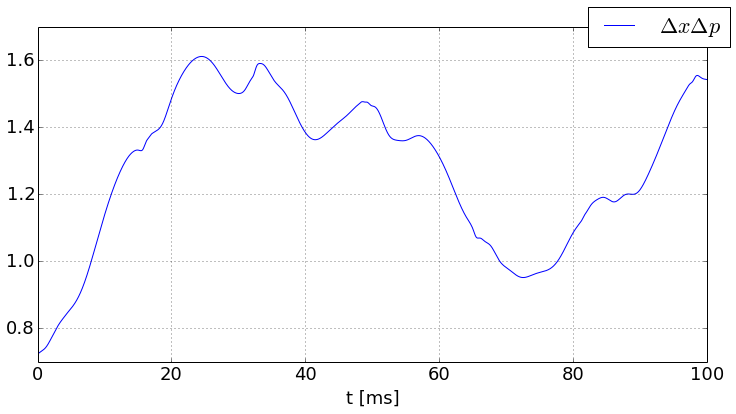

In [16]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot( instance.timeRange*instance.timeScale ,
np.sqrt(instance.X2_average - instance.X_average**2)*np.sqrt(instance.P2_average - instance.P_average**2)
        , '-' , label = '$\\Delta x \\Delta p$' , linewidth=1.)


ax.legend(bbox_to_anchor=(1.05, 1), loc=5, prop={'size':22})
#ax.set_ylim(-50, 0)
ax.set_xlabel('t [ms]')
#ax.set_xlim(0,41000)
ax.set_ylabel(' ')
ax.grid();


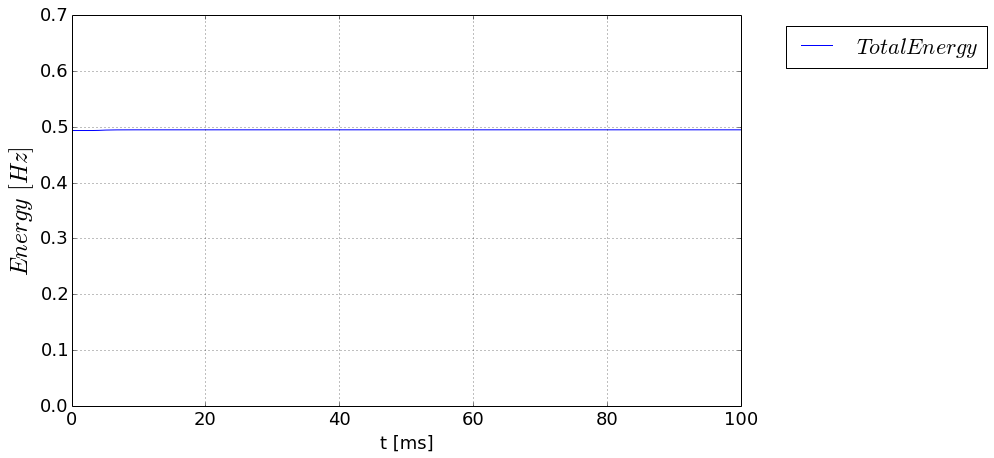

In [17]:
fig, ax = plt.subplots(figsize=(12, 7))

energyList = instance.Hamiltonian_average + 0.5*instance.GPitaevskiiCoeff*instance.ProbabilitySquare_average

ax.plot( instance.timeRange* instance.timeScale , 
 instance.energyScale*energyList , '-' , label = '$Total Energy$' , linewidth=1.)


ax.legend(bbox_to_anchor=(1.05, 1), loc=2, prop={'size':22})
ax.set_ylim( 0 , 0.7)
ax.set_xlabel('t [ms]')
#ax.set_ylabel(' ')
ax.set_ylabel('$ Energy \, [Hz]$', **axis_font  )
ax.grid();

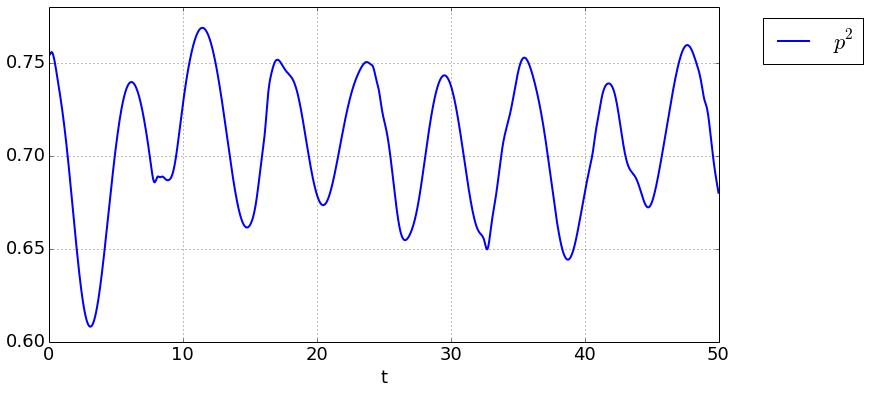

In [18]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot( instance.timeRange , \
          np.sqrt(instance.P2_average - instance.P_average**2) \
         , '-' , label = '$p^2 $',linewidth=2.)

#ax.plot( instance.timeRange , instance.X3_average - 2*gamma*instance.P_average , '-' ,
#        label = '$-F-2\gamma <P>$' ,linewidth=2.)

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, prop={'size':22})
#ax.set_ylim(- 12 , 7)
ax.set_xlabel('t')
ax.set_ylabel(' ')
ax.grid();

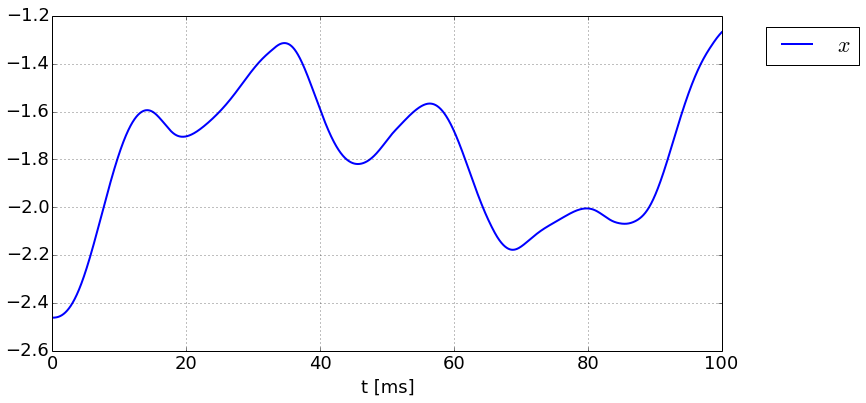

In [19]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot( instance.timeRange*instance.timeScale , instance.X_average \
         , '-' , label = '$x$',linewidth=2.)

#ax.plot( instance.timeRange , instance.X3_average - 2*gamma*instance.P_average , '-' ,
#        label = '$-F-2\gamma <P>$' ,linewidth=2.)

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, prop={'size':22})
#ax.set_ylim(- 12 , 7)
ax.set_xlabel('t [ms]')
ax.set_ylabel(' ')
ax.grid();

## Loading saved File

In [20]:
W = instance.WignerFunctionFromFile(instance.skipFrames)

min =  -0.0168189698083  max =  0.234221116146
normalization =  0.999999999998


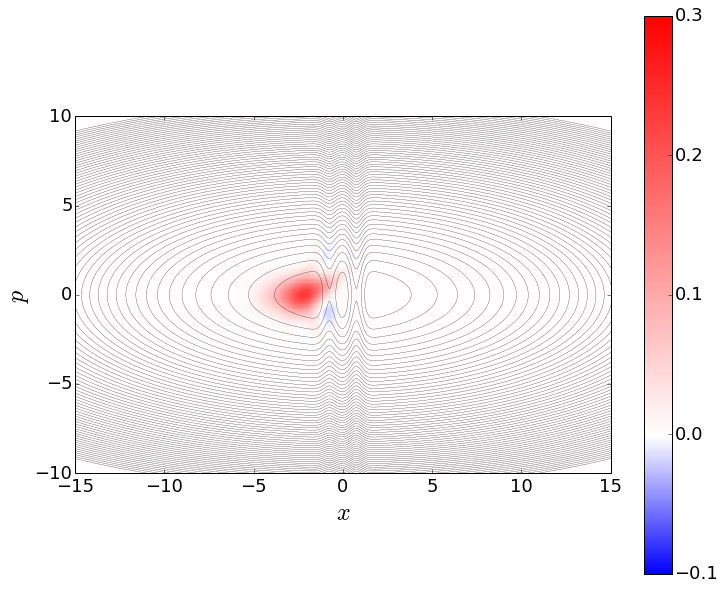

In [21]:
instance.PlotWignerFrame( W.real , plotRange=((-15.,15) ,(-10,10))  
                         , global_color=(-0.1,0.3), energy_Levels=(0,60,1));

In [22]:
def RightProbability( nFrame, xIndexTruncation):
    W = instance.WignerFunctionFromFile(nFrame).real
    prob_x = fftpack.fftshift(  instance.WignerMarginal_Probability_x(W)  ) 
    #return prob_x
    return np.sum( prob_x[xIndexTruncation:] )*instance.dX

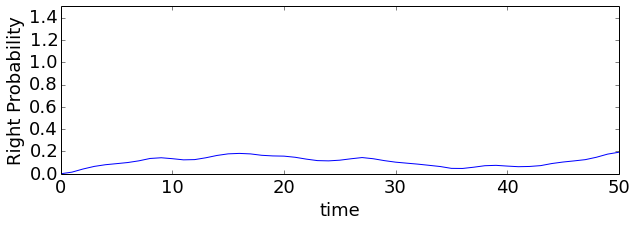

In [23]:
fig, ax = plt.subplots(figsize=(10, 10))


timeLine = instance.dt*np.arange(0,instance.timeSteps+instance.skipFrames,instance.skipFrames)

prob = map( lambda n: RightProbability(n,512),  range(0,instance.timeSteps+instance.skipFrames,instance.skipFrames) )


ax.plot(  prob )
ax.set_ylim(0,1.5)
ax.set_xlabel('time')
ax.set_ylabel('Right Probability')
ax.set_aspect(10)